In [4]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt').read().splitlines()

In [7]:
alphabet = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(alphabet)}
stoi['.'] = 0
itos = {v:k for k, v in stoi.items()}

In [8]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    context = [0] * 3
    for word in words:
        for ch in word + '.':
            #print("".join(itos[i] for i in context)+f' ---> {ch}')
            yidx = stoi[ch]
            X.append(context)
            Y.append(yidx)
            context = context[1:] + [yidx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
n_embed = 10
n_layer2 = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embed), requires_grad=True, generator=g)
n_inputs = block_size * n_embed
W1 = torch.randn((n_inputs, n_layer2), requires_grad=True, generator=g)
B1 = torch.randn(n_layer2, requires_grad=True, generator=g)
W2 = torch.randn((n_layer2, 27), requires_grad=True, generator=g)
B2 = torch.randn(27, requires_grad=True, generator=g)
parameters = [C, W1, B1, W2, B2]

In [10]:
count = 0
for p in parameters:
    count += p.nelement()
count

11897

In [17]:
# Gradient Descent
for i in range(200000):
    lr = 0.1 if i < 100000 else 0.01
    # Forward Pass
    ix_batch = torch.randint(0, Xtr.shape[0], (64,)) # ---> Get indexes to create a batch of 64 examples
    batch = Xtr[ix_batch] # Batch of 64 examples to train on
    # Layer 1 - Input Layer
    emb = C[batch]
    act1 = emb.view(-1, n_inputs) @ W1 + B1
    h = torch.tanh(act1)
    # Layer 2 - Hidden Layer with 100 neurons
    act2 = h @ W2 + B2
    # Layer 3 - Output Layer softmax
    loss = F.cross_entropy(act2, Ytr[ix_batch])
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad

    if i == 0 or (i+1) % 10000 == 0:
        print(f'LearningRate: {lr}, Loss: {loss.item(): .4f}')

LearningRate: 0.1, Loss:  23.5762
LearningRate: 0.1, Loss:  2.2612
LearningRate: 0.1, Loss:  2.1768
LearningRate: 0.1, Loss:  2.1910
LearningRate: 0.1, Loss:  2.7340
LearningRate: 0.1, Loss:  2.2709
LearningRate: 0.1, Loss:  2.3954
LearningRate: 0.1, Loss:  2.2556
LearningRate: 0.1, Loss:  2.5837
LearningRate: 0.1, Loss:  2.1886
LearningRate: 0.1, Loss:  1.7472
LearningRate: 0.01, Loss:  2.0195
LearningRate: 0.01, Loss:  2.1902
LearningRate: 0.01, Loss:  2.0474
LearningRate: 0.01, Loss:  2.1928
LearningRate: 0.01, Loss:  2.1785
LearningRate: 0.01, Loss:  2.2037
LearningRate: 0.01, Loss:  2.2453
LearningRate: 0.01, Loss:  2.1312
LearningRate: 0.01, Loss:  2.2829
LearningRate: 0.01, Loss:  2.3813


In [18]:
@torch.no_grad() # disables gradient tracking
def evaluate(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    print(X.shape, Y.shape)
    emb = C[X]
    logits1 = emb.view(-1, n_inputs) @ W1 + B1
    act1 = torch.tanh(logits1)
    logits2 = act1 @ W2 + B2
    loss = F.cross_entropy(logits2, Y)
    print(loss.item())

evaluate('train')
evaluate('dev')

torch.Size([182625, 3]) torch.Size([182625])
2.1294162273406982
torch.Size([22655, 3]) torch.Size([22655])
2.1657228469848633


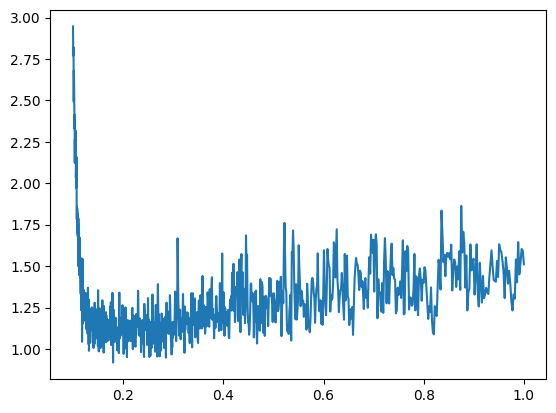

In [31]:
plt.plot(lri, lossi)

In [19]:
evaluate('test')

torch.Size([22866, 3]) torch.Size([22866])
2.164968729019165


In [22]:
g = torch.Generator().manual_seed(2147483647+25)
@torch.no_grad()
def generate(n):
    for i in range(n):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])]
            logits1 = emb.view(-1, n_inputs) @ W1 + B1
            act1 = torch.tanh(logits1)
            logits2 = act1 @ W2 + B2
            probs = F.softmax(logits2, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itos[ix] for ix in out))
            
generate(20)

rxyn.
rograana.
raimsyn.
axti.
rolan.
rxeu.
roni.
rose.
ixa.
rquella.
kariaton.
rowt.
roska.
regend.
qhinth.
roz.
ramoee.
qhin.
rxetre.
ray.
